In [1]:
# Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# initial condition

def initial_condition(x):
    return -torch.sin(pi*x)

In [3]:
# assigning number of points
initial_pts = 200
left_boundary_pts = 200
right_boundary_pts = 200
residual_pts = 1000

In [4]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

### Initial and boundary conditions

In [5]:
#first condition
x_init = 2*torch.rand((initial_pts,1)) - 1 # initial pts (basically torch.rand generate the value between 0 to 1 but domain is (-1,1) so 2(0,1)-1)
t_init =  0*x_init                            #t=0
init =  torch.cat([x_init, t_init],1)                   #concatinate the variable x and t
u_init = initial_condition(init[:,0]).reshape(-1, 1)     #u(0,x)=-sin(pix) (initial condition)



#second condition
xb_left = -torch.ones((left_boundary_pts, 1)) # left spatial boundary #u(t,-1) [boundary condition]  generate the value of x when t is -1
tb_left = torch.rand((left_boundary_pts, 1)) #randomly generate the value of t
b_left = torch.cat([xb_left, tb_left ],1)    #concatinate
u_b_l = 0*xb_left            #u(t,-1)=0 [boundary condition]


#third condition
xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary,u(t,1)  generate the value of x when t is 1
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)   #concatinate
u_b_r = 0*xb_right                              #u(t,1)=0 [boundary condition]

#fourth conditon for interior points
x_interior = 2*torch.rand((residual_pts, 1))-1   #randomy generate the value of x in domain
t_interior = torch.rand((residual_pts, 1))        #randomly generate the value of t in [0,1]
interior = torch.cat([x_interior, t_interior],1)   #concatinate

training_set = DataLoader(torch.utils.data.TensorDataset(init, u_init, b_left, b_right), batch_size=200, shuffle=False)


### Neural network class

In [6]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        x = self.activation(self.input_layer(x))   
        for k, l in enumerate(self.hidden_layers):  
            x = self.activation(l(x))                         
        return self.output_layer(x)       


In [7]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=20)

In [8]:
# Model definition (for good intialisation)
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)

In [9]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


In [10]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, u_initial, bd_left,  bd_right) in enumerate(training_set):

            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                u_initial_pred_ = model(initial)
                # for left boundary
                u_bd_left_pred_ = model(bd_left)
                # for right boundary
                u_bd_right_pred_ = model(bd_right)

                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0]
                u_t =  grad_u_hat[:, 1]

                grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xx = grad_grad_u_x[:, 0]

                # Item 1. below
                loss = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, ))**p) + torch.mean((u_t.reshape(-1, ) + (u_hat.reshape(-1, )*u_x.reshape(-1, )).reshape(-1, ) - (0.01/pi)*u_xx.reshape(-1, ))**p) +torch.mean((u_bd_left_pred_.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,))**p)


                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


n_epochs = 3500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  51.86415481567383
################################  1  ################################
Loss:  50.639556884765625
################################  2  ################################
Loss:  42.89594268798828
################################  3  ################################
Loss:  34.37834930419922
################################  4  ################################
Loss:  26.722042083740234
################################  5  ################################
Loss:  20.997289657592773
################################  6  ################################
Loss:  16.75794219970703
################################  7  ################################
Loss:  13.54272174835205
################################  8  ################################
Loss:  11.039069175720215
################################  9  ################################
Loss:  9.00601577758789
################################  10  #########

Loss:  0.13766461610794067
################################  86  ################################
Loss:  0.13673166930675507
################################  87  ################################
Loss:  0.13586431741714478
################################  88  ################################
Loss:  0.13502971827983856
################################  89  ################################
Loss:  0.13426798582077026
################################  90  ################################
Loss:  0.13353748619556427
################################  91  ################################
Loss:  0.13287873566150665
################################  92  ################################
Loss:  0.13226215541362762
################################  93  ################################
Loss:  0.13168329000473022
################################  94  ################################
Loss:  0.13112248480319977
################################  95  ################################
Loss:  0.13056087493

Loss:  0.09461659938097
################################  186  ################################
Loss:  0.09439753741025925
################################  187  ################################
Loss:  0.09417508542537689
################################  188  ################################
Loss:  0.09394800662994385
################################  189  ################################
Loss:  0.09371532499790192
################################  190  ################################
Loss:  0.09347563236951828
################################  191  ################################
Loss:  0.0932241678237915
################################  192  ################################
Loss:  0.09299583733081818
################################  193  ################################
Loss:  0.0927560105919838
################################  194  ################################
Loss:  0.09250500053167343
################################  195  ################################
Loss:  0.092262

Loss:  0.055125102400779724
################################  294  ################################
Loss:  0.05458207428455353
################################  295  ################################
Loss:  0.054055243730545044
################################  296  ################################
Loss:  0.05357535928487778
################################  297  ################################
Loss:  0.05313656106591225
################################  298  ################################
Loss:  0.05273952707648277
################################  299  ################################
Loss:  0.05236523225903511
################################  300  ################################
Loss:  0.05200754851102829
################################  301  ################################
Loss:  0.05165102332830429
################################  302  ################################
Loss:  0.051292452961206436
################################  303  ################################
Loss:  

Loss:  0.0269866194576025
################################  385  ################################
Loss:  0.026905322447419167
################################  386  ################################
Loss:  0.026821814477443695
################################  387  ################################
Loss:  0.026751389726996422
################################  388  ################################
Loss:  0.026687875390052795
################################  389  ################################
Loss:  0.02660556696355343
################################  390  ################################
Loss:  0.026507223024964333
################################  391  ################################
Loss:  0.02640128694474697
################################  392  ################################
Loss:  0.02628418616950512
################################  393  ################################
Loss:  0.026157701388001442
################################  394  ################################
Loss:

Loss:  0.0171272624284029
################################  476  ################################
Loss:  0.016996843740344048
################################  477  ################################
Loss:  0.016871949657797813
################################  478  ################################
Loss:  0.016737567260861397
################################  479  ################################
Loss:  0.016606979072093964
################################  480  ################################
Loss:  0.01648092083632946
################################  481  ################################
Loss:  0.016353096812963486
################################  482  ################################
Loss:  0.01622895337641239
################################  483  ################################
Loss:  0.016098683699965477
################################  484  ################################
Loss:  0.015975983813405037
################################  485  ################################
Loss

Loss:  0.009221881628036499
################################  564  ################################
Loss:  0.009130063466727734
################################  565  ################################
Loss:  0.009039957076311111
################################  566  ################################
Loss:  0.008949516341090202
################################  567  ################################
Loss:  0.00886405911296606
################################  568  ################################
Loss:  0.008783536963164806
################################  569  ################################
Loss:  0.008708496578037739
################################  570  ################################
Loss:  0.008634273894131184
################################  571  ################################
Loss:  0.008561826311051846
################################  572  ################################
Loss:  0.008488730527460575
################################  573  ################################
L

Loss:  0.004576115403324366
################################  660  ################################
Loss:  0.004555573686957359
################################  661  ################################
Loss:  0.004534755367785692
################################  662  ################################
Loss:  0.004513774998486042
################################  663  ################################
Loss:  0.004492556676268578
################################  664  ################################
Loss:  0.004466833546757698
################################  665  ################################
Loss:  0.004444499500095844
################################  666  ################################
Loss:  0.004422035533934832
################################  667  ################################
Loss:  0.004397569689899683
################################  668  ################################
Loss:  0.004371983464807272
################################  669  ################################


Loss:  0.002658705459907651
################################  743  ################################
Loss:  0.002644643886014819
################################  744  ################################
Loss:  0.0026308789383620024
################################  745  ################################
Loss:  0.0026169228367507458
################################  746  ################################
Loss:  0.0026030836161226034
################################  747  ################################
Loss:  0.002588694216683507
################################  748  ################################
Loss:  0.0025748214684426785
################################  749  ################################
Loss:  0.002560444874688983
################################  750  ################################
Loss:  0.0025454119313508272
################################  751  ################################
Loss:  0.002530367113649845
################################  752  ############################

Loss:  0.0017942438134923577
################################  829  ################################
Loss:  0.0017870181472972035
################################  830  ################################
Loss:  0.0017806345131248236
################################  831  ################################
Loss:  0.0017735926667228341
################################  832  ################################
Loss:  0.0017654671100899577
################################  833  ################################
Loss:  0.0017583249136805534
################################  834  ################################
Loss:  0.0017506831791251898
################################  835  ################################
Loss:  0.0017435053596273065
################################  836  ################################
Loss:  0.001736955251544714
################################  837  ################################
Loss:  0.0017301705665886402
################################  838  ########################

Loss:  0.0012518103467300534
################################  922  ################################
Loss:  0.0012466015759855509
################################  923  ################################
Loss:  0.0012410723138600588
################################  924  ################################
Loss:  0.0012343378039076924
################################  925  ################################
Loss:  0.0012279701186344028
################################  926  ################################
Loss:  0.0012210754211992025
################################  927  ################################
Loss:  0.001214086776599288
################################  928  ################################
Loss:  0.0012066358467563987
################################  929  ################################
Loss:  0.0011982240248471498
################################  930  ################################
Loss:  0.0011891733156517148
################################  931  ########################

Loss:  0.0007878538453951478
################################  1013  ################################
Loss:  0.0007850256515666842
################################  1014  ################################
Loss:  0.0007820881437510252
################################  1015  ################################
Loss:  0.0007790838135406375
################################  1016  ################################
Loss:  0.0007760252337902784
################################  1017  ################################
Loss:  0.0007728557684458792
################################  1018  ################################
Loss:  0.0007694284431636333
################################  1019  ################################
Loss:  0.0007661916315555573
################################  1020  ################################
Loss:  0.000762861454859376
################################  1021  ################################
Loss:  0.0007593699847348034
################################  1022  ##############

Loss:  0.00048376023187302053
################################  1108  ################################
Loss:  0.0004808841331396252
################################  1109  ################################
Loss:  0.0004780327435582876
################################  1110  ################################
Loss:  0.00047555594937875867
################################  1111  ################################
Loss:  0.0004731494700536132
################################  1112  ################################
Loss:  0.00047059435746632516
################################  1113  ################################
Loss:  0.0004680700658354908
################################  1114  ################################
Loss:  0.00046537703019566834
################################  1115  ################################
Loss:  0.00046263649710454047
################################  1116  ################################
Loss:  0.00045968976337462664
################################  1117  #######

Loss:  0.0002690893888939172
################################  1195  ################################
Loss:  0.0002671083202585578
################################  1196  ################################
Loss:  0.00026524055283516645
################################  1197  ################################
Loss:  0.0002632431860547513
################################  1198  ################################
Loss:  0.0002614608674775809
################################  1199  ################################
Loss:  0.0002596798585727811
################################  1200  ################################
Loss:  0.0002580315340310335
################################  1201  ################################
Loss:  0.00025641999673098326
################################  1202  ################################
Loss:  0.00025476200971752405
################################  1203  ################################
Loss:  0.0002531450882088393
################################  1204  ##########

Loss:  0.00015208417607937008
################################  1306  ################################
Loss:  0.00015092141984496266
################################  1307  ################################
Loss:  0.0001497995835961774
################################  1308  ################################
Loss:  0.00014869525330141187
################################  1309  ################################
Loss:  0.00014764934894628823
################################  1310  ################################
Loss:  0.00014663655019830912
################################  1311  ################################
Loss:  0.00014563766308128834
################################  1312  ################################
Loss:  0.0001447660761186853
################################  1313  ################################
Loss:  0.0001439449260942638
################################  1314  ################################
Loss:  0.00014325184747576714
################################  1315  ######

Loss:  9.8068019724451e-05
################################  1411  ################################
Loss:  9.773904457688332e-05
################################  1412  ################################
Loss:  9.738466906128451e-05
################################  1413  ################################
Loss:  9.69652392086573e-05
################################  1414  ################################
Loss:  9.661643707659096e-05
################################  1415  ################################
Loss:  9.602950740372762e-05
################################  1416  ################################
Loss:  9.568609675625339e-05
################################  1417  ################################
Loss:  9.530722309136763e-05
################################  1418  ################################
Loss:  9.48626984609291e-05
################################  1419  ################################
Loss:  9.434553794562817e-05
################################  1420  #################

Loss:  6.722144462401047e-05
################################  1516  ################################
Loss:  6.692953320452943e-05
################################  1517  ################################
Loss:  6.662075611529872e-05
################################  1518  ################################
Loss:  6.63831306155771e-05
################################  1519  ################################
Loss:  6.615817983401939e-05
################################  1520  ################################
Loss:  6.594272417714819e-05
################################  1521  ################################
Loss:  6.57411728752777e-05
################################  1522  ################################
Loss:  6.55396725051105e-05
################################  1523  ################################
Loss:  6.535740976687521e-05
################################  1524  ################################
Loss:  6.51833470328711e-05
################################  1525  #################

Loss:  5.240780956228264e-05
################################  1608  ################################
Loss:  5.229930320638232e-05
################################  1609  ################################
Loss:  5.217686702962965e-05
################################  1610  ################################
Loss:  5.2051404054509476e-05
################################  1611  ################################
Loss:  5.1925439038313925e-05
################################  1612  ################################
Loss:  5.1798760978272185e-05
################################  1613  ################################
Loss:  5.167532799532637e-05
################################  1614  ################################
Loss:  5.15451974933967e-05
################################  1615  ################################
Loss:  5.143773523741402e-05
################################  1616  ################################
Loss:  5.1321054343134165e-05
################################  1617  ##########

Loss:  4.133315815124661e-05
################################  1701  ################################
Loss:  4.120771336602047e-05
################################  1702  ################################
Loss:  4.111019734409638e-05
################################  1703  ################################
Loss:  4.10053544328548e-05
################################  1704  ################################
Loss:  4.08812629757449e-05
################################  1705  ################################
Loss:  4.074315438629128e-05
################################  1706  ################################
Loss:  4.061890285811387e-05
################################  1707  ################################
Loss:  4.0493643609806895e-05
################################  1708  ################################
Loss:  4.037890175823122e-05
################################  1709  ################################
Loss:  4.0255959902424365e-05
################################  1710  #############

Loss:  3.0205123039195314e-05
################################  1798  ################################
Loss:  3.0082584999036044e-05
################################  1799  ################################
Loss:  2.998144191224128e-05
################################  1800  ################################
Loss:  2.9872022423660383e-05
################################  1801  ################################
Loss:  2.9780017939629033e-05
################################  1802  ################################
Loss:  2.9669516152353026e-05
################################  1803  ################################
Loss:  2.958046388812363e-05
################################  1804  ################################
Loss:  2.9488082873285748e-05
################################  1805  ################################
Loss:  2.938368015747983e-05
################################  1806  ################################
Loss:  2.926391789515037e-05
################################  1807  #######

Loss:  2.4002394638955593e-05
################################  1895  ################################
Loss:  2.394198781985324e-05
################################  1896  ################################
Loss:  2.3902455723145977e-05
################################  1897  ################################
Loss:  2.3859358407207765e-05
################################  1898  ################################
Loss:  2.381131889706012e-05
################################  1899  ################################
Loss:  2.376609882048797e-05
################################  1900  ################################
Loss:  2.371863774897065e-05
################################  1901  ################################
Loss:  2.3674103431403637e-05
################################  1902  ################################
Loss:  2.3631284420844167e-05
################################  1903  ################################
Loss:  2.3588996555190533e-05
################################  1904  #######

Loss:  2.0211058654240333e-05
################################  1978  ################################
Loss:  2.0190538634778932e-05
################################  1979  ################################
Loss:  2.0171848518657498e-05
################################  1980  ################################
Loss:  2.0150695490883663e-05
################################  1981  ################################
Loss:  2.0129680706304498e-05
################################  1982  ################################
Loss:  2.0106013835174963e-05
################################  1983  ################################
Loss:  2.0087563825654797e-05
################################  1984  ################################
Loss:  2.0068895537406206e-05
################################  1985  ################################
Loss:  2.0045858036610298e-05
################################  1986  ################################
Loss:  2.0026840502396226e-05
################################  1987  ###

Loss:  1.7229653167305514e-05
################################  2082  ################################
Loss:  1.7188425772474147e-05
################################  2083  ################################
Loss:  1.714786412776448e-05
################################  2084  ################################
Loss:  1.7108835891122e-05
################################  2085  ################################
Loss:  1.707312731014099e-05
################################  2086  ################################
Loss:  1.7036860299413092e-05
################################  2087  ################################
Loss:  1.700399116089102e-05
################################  2088  ################################
Loss:  1.6975713151623495e-05
################################  2089  ################################
Loss:  1.696814979368355e-05
################################  2090  ################################
Loss:  1.694148886599578e-05
################################  2091  ###########

Loss:  1.513288043497596e-05
################################  2168  ################################
Loss:  1.510106540081324e-05
################################  2169  ################################
Loss:  1.5064552826515865e-05
################################  2170  ################################
Loss:  1.5030842405394651e-05
################################  2171  ################################
Loss:  1.5000920939201023e-05
################################  2172  ################################
Loss:  1.4973363249737304e-05
################################  2173  ################################
Loss:  1.494844036642462e-05
################################  2174  ################################
Loss:  1.492574028816307e-05
################################  2175  ################################
Loss:  1.4903301234880928e-05
################################  2176  ################################
Loss:  1.4885730706737377e-05
################################  2177  #######

Loss:  1.2936471648572478e-05
################################  2264  ################################
Loss:  1.2910678378830198e-05
################################  2265  ################################
Loss:  1.2882715054729488e-05
################################  2266  ################################
Loss:  1.2854596207034774e-05
################################  2267  ################################
Loss:  1.2827977116103284e-05
################################  2268  ################################
Loss:  1.2802487617591396e-05
################################  2269  ################################
Loss:  1.2779162716469727e-05
################################  2270  ################################
Loss:  1.2757688637066167e-05
################################  2271  ################################
Loss:  1.2738162695313804e-05
################################  2272  ################################
Loss:  1.2720402992272284e-05
################################  2273  ###

Loss:  1.1606425687205046e-05
################################  2353  ################################
Loss:  1.1591291695367545e-05
################################  2354  ################################
Loss:  1.1575369171623606e-05
################################  2355  ################################
Loss:  1.1559497579582967e-05
################################  2356  ################################
Loss:  1.154354049504036e-05
################################  2357  ################################
Loss:  1.1527936294442043e-05
################################  2358  ################################
Loss:  1.1512826858961489e-05
################################  2359  ################################
Loss:  1.1494706086523365e-05
################################  2360  ################################
Loss:  1.1477534826553892e-05
################################  2361  ################################
Loss:  1.14586609925027e-05
################################  2362  ######

Loss:  1.056447308656061e-05
################################  2444  ################################
Loss:  1.0556705092312768e-05
################################  2445  ################################
Loss:  1.0548865247983485e-05
################################  2446  ################################
Loss:  1.0541144547460135e-05
################################  2447  ################################
Loss:  1.0533514796406962e-05
################################  2448  ################################
Loss:  1.0525703146413434e-05
################################  2449  ################################
Loss:  1.051762683346169e-05
################################  2450  ################################
Loss:  1.0509382263990119e-05
################################  2451  ################################
Loss:  1.0501378710614517e-05
################################  2452  ################################
Loss:  1.0494468369870447e-05
################################  2453  #####

Loss:  9.431378202862106e-06
################################  2537  ################################
Loss:  9.41993039305089e-06
################################  2538  ################################
Loss:  9.409445738128852e-06
################################  2539  ################################
Loss:  9.399114787811413e-06
################################  2540  ################################
Loss:  9.389841579832137e-06
################################  2541  ################################
Loss:  9.380705705552828e-06
################################  2542  ################################
Loss:  9.37004733714275e-06
################################  2543  ################################
Loss:  9.361841875943355e-06
################################  2544  ################################
Loss:  9.353136192657985e-06
################################  2545  ################################
Loss:  9.345622856926639e-06
################################  2546  ###############

Loss:  8.459101991320495e-06
################################  2635  ################################
Loss:  8.452025213046e-06
################################  2636  ################################
Loss:  8.445004823443014e-06
################################  2637  ################################
Loss:  8.438170880253892e-06
################################  2638  ################################
Loss:  8.431492460658774e-06
################################  2639  ################################
Loss:  8.425575288129039e-06
################################  2640  ################################
Loss:  8.41947075969074e-06
################################  2641  ################################
Loss:  8.413316209043842e-06
################################  2642  ################################
Loss:  8.408020221395418e-06
################################  2643  ################################
Loss:  8.402484127145726e-06
################################  2644  #################

Loss:  7.652773092559073e-06
################################  2732  ################################
Loss:  7.64559990784619e-06
################################  2733  ################################
Loss:  7.63901789468946e-06
################################  2734  ################################
Loss:  7.632417691638693e-06
################################  2735  ################################
Loss:  7.626282240380533e-06
################################  2736  ################################
Loss:  7.620486030646134e-06
################################  2737  ################################
Loss:  7.6150695349497255e-06
################################  2738  ################################
Loss:  7.609348813275574e-06
################################  2739  ################################
Loss:  7.604152415296994e-06
################################  2740  ################################
Loss:  7.598949650855502e-06
################################  2741  ##############

Loss:  6.685819244012237e-06
################################  2831  ################################
Loss:  6.676260454696603e-06
################################  2832  ################################
Loss:  6.667137313343119e-06
################################  2833  ################################
Loss:  6.65812967781676e-06
################################  2834  ################################
Loss:  6.649885108345188e-06
################################  2835  ################################
Loss:  6.640601441176841e-06
################################  2836  ################################
Loss:  6.632833901676349e-06
################################  2837  ################################
Loss:  6.624832167290151e-06
################################  2838  ################################
Loss:  6.616778136958601e-06
################################  2839  ################################
Loss:  6.608740022784332e-06
################################  2840  ##############

Loss:  5.9240041991870385e-06
################################  2928  ################################
Loss:  5.9203352975600865e-06
################################  2929  ################################
Loss:  5.916939699091017e-06
################################  2930  ################################
Loss:  5.9121202866663225e-06
################################  2931  ################################
Loss:  5.907822924200445e-06
################################  2932  ################################
Loss:  5.902286829950754e-06
################################  2933  ################################
Loss:  5.897953997191507e-06
################################  2934  ################################
Loss:  5.89291266805958e-06
################################  2935  ################################
Loss:  5.887266070203623e-06
################################  2936  ################################
Loss:  5.88011880608974e-06
################################  2937  ############

Loss:  5.374341526476201e-06
################################  3027  ################################
Loss:  5.370459348341683e-06
################################  3028  ################################
Loss:  5.367114681575913e-06
################################  3029  ################################
Loss:  5.3638441386283375e-06
################################  3030  ################################
Loss:  5.360770956031047e-06
################################  3031  ################################
Loss:  5.358221187634626e-06
################################  3032  ################################
Loss:  5.355250323191285e-06
################################  3033  ################################
Loss:  5.352738298824988e-06
################################  3034  ################################
Loss:  5.349772436602507e-06
################################  3035  ################################
Loss:  5.347389105736511e-06
################################  3036  ############

Loss:  5.081438757770229e-06
################################  3119  ################################
Loss:  5.076833986095153e-06
################################  3120  ################################
Loss:  5.071948180557229e-06
################################  3121  ################################
Loss:  5.067505298939068e-06
################################  3122  ################################
Loss:  5.062627224106109e-06
################################  3123  ################################
Loss:  5.057589078205638e-06
################################  3124  ################################
Loss:  5.05201933265198e-06
################################  3125  ################################
Loss:  5.046988007961772e-06
################################  3126  ################################
Loss:  5.041998974775197e-06
################################  3127  ################################
Loss:  5.036504717281787e-06
################################  3128  ##############

Loss:  4.6788063627900556e-06
################################  3213  ################################
Loss:  4.675596755987499e-06
################################  3214  ################################
Loss:  4.672317572840257e-06
################################  3215  ################################
Loss:  4.668778274208307e-06
################################  3216  ################################
Loss:  4.665947471949039e-06
################################  3217  ################################
Loss:  4.663074832933489e-06
################################  3218  ################################
Loss:  4.6601180656580254e-06
################################  3219  ################################
Loss:  4.656932105717715e-06
################################  3220  ################################
Loss:  4.652973984775599e-06
################################  3221  ################################
Loss:  4.649861239158781e-06
################################  3222  ###########

Loss:  4.266003998054657e-06
################################  3309  ################################
Loss:  4.262934908183524e-06
################################  3310  ################################
Loss:  4.259781690052478e-06
################################  3311  ################################
Loss:  4.256733063812135e-06
################################  3312  ################################
Loss:  4.2535980355751235e-06
################################  3313  ################################
Loss:  4.250951860740315e-06
################################  3314  ################################
Loss:  4.248027380526764e-06
################################  3315  ################################
Loss:  4.245188847562531e-06
################################  3316  ################################
Loss:  4.242853265168378e-06
################################  3317  ################################
Loss:  4.240338512317976e-06
################################  3318  ############

Loss:  3.972137164964806e-06
################################  3406  ################################
Loss:  3.969479166698875e-06
################################  3407  ################################
Loss:  3.967303200624883e-06
################################  3408  ################################
Loss:  3.965112227888312e-06
################################  3409  ################################
Loss:  3.962868959206389e-06
################################  3410  ################################
Loss:  3.960574758821167e-06
################################  3411  ################################
Loss:  3.957986791647272e-06
################################  3412  ################################
Loss:  3.955742158723297e-06
################################  3413  ################################
Loss:  3.953490249841707e-06
################################  3414  ################################
Loss:  3.951116013922729e-06
################################  3415  #############

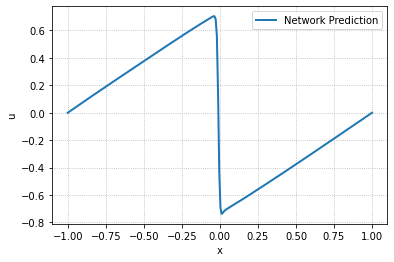

In [11]:
x_test = torch.linspace(-1, 1, 256).reshape(-1,1)
t_test = torch.ones(256).reshape(-1,1)
test = torch.cat([x_test, t_test],1)

my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)


plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

x_shape (256, 1)
t_shape (100, 1)
u_shape (256, 100)


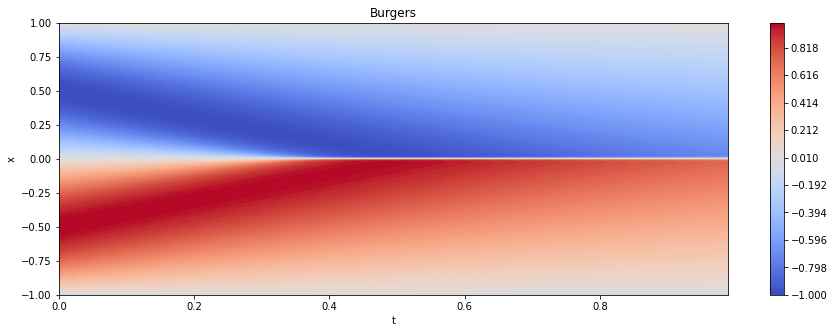

In [12]:
# Exact solution from fdm

import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io




# Set random seed for reproducibility
torch.manual_seed(42)

# Toy problem data
input_size = 256
hidden_size = 32
output_size = 256
sequence_length = 75
batch_size = 1
num_epochs = 20000

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the .mat file
mat_data = scipy.io.loadmat('burgers_shock.mat')

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u = mat_data['usol']

# Use the loaded variables as needed
print("x_shape", x.shape)
print("t_shape", t.shape)
print("u_shape", u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u), np.max(u), 100)

# Plot the contour
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burgers')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()


In [13]:
import torch

u_sol = torch.zeros(100, 256)
x_test = torch.linspace(-1, 1, 256).reshape(-1, 1)
t_test = torch.zeros(256).reshape(-1, 1)
dt = 0.01

# # Assuming my_network is your defined neural network model
# my_network = YourNetworkModel()

for i in range(100):
      # Increment t_test by dt
    test = torch.cat([x_test, t_test], dim=1)
  
  
    output = my_network(test)
    t_test += dt
    u_sol[i, :] = output.reshape(256)  # Reshape output to match u_sol[i, :]

# Rest of your code...
u1 = u_sol.T


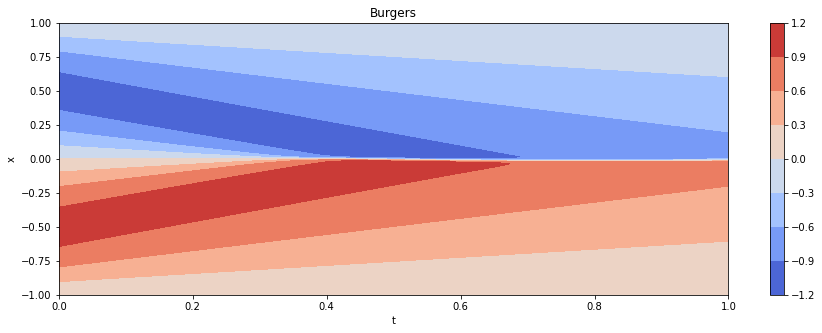

In [14]:
x = np.linspace(-1, 1, 256)
t = np.linspace(0, 1, 100)

X, T = np.meshgrid(x, t)
# # Define custom color levels
#c_levels = np.linspace(np.min(u), np.max(u), 100)
u1 = u1.detach().numpy()
# Plot the contour
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u1.T, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burgers')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

### Error percent

In [15]:
import numpy as np
import torch

# Assuming u_test_pred and u_test are your PyTorch tensors

# Convert PyTorch tensors to NumPy arrays
u_test_pred_np = u1
u_test_np = u

# Compute the relative L2 error norm (generalization error)
relative_error_test = np.mean((u_test_pred_np - u_test_np)**2) / np.mean(u_test_np**2)
print("Relative Error Test: ", relative_error_test * 100, "%")


Relative Error Test:  1.0340189074542334 %


In [19]:
import numpy as np
import scipy.io

# Example data
data = {
    'x': x,
    't': t,
    'u1': u,
}

# Save data to .mat file
file_path = 'burg.mat'
scipy.io.savemat(file_path, data)
